In [1]:
import numpy as np
import awkward as ak
import warnings
import matplotlib.pyplot as plt
import hist
import math
import os
import json
import gc
import dask_awkward as dak
import mplhep as hep
from scipy.stats import kstest

In [ ]:
# plt.style.use(hep.style.CMS)

In [2]:
warnings.filterwarnings('ignore', 'invalid value')
warnings.filterwarnings('ignore', 'divide by')
warnings.filterwarnings('ignore', 'overflow encountered')
warnings.filterwarnings('ignore', 'Conversion of an array')

In [3]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)

In [4]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [5]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [6]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [7]:
def read_files(input_path):
    if ('.parquet' in os.listdir(input_path)[0]):
        output = ak.from_parquet(f'{input_path}/*', columns=columns)
    else:
        output = {}
        for i in os.listdir(input_path):
            if ('flat400' not in i):
                output[i] = ak.from_parquet(f'{input_path}/{i}/*', columns=columns)
            else:
                continue
    return output

In [8]:
def firsts(mc):
    for i in mc:
        if type(mc[i]) == dict:
            for j in mc[i]:
                for k in mc[i][j].fields:
                    if 'event' in k:
                        continue
                    else:
                        try:
                            mc[i][j][k] = ak.firsts(mc[i][j][k])
                        except:
                            continue
        else:
            for j in mc[i].fields:
                if 'event' in j:
                    continue
                else:
                    try:
                        mc[i][j] = ak.firsts(mc[i][j])
                    except:
                        continue
    return mc

In [9]:
upper = 1000
lower = 475
IL = 44.99

In [54]:
path = '/cms/cephfs/data/store/user/cmoore24/skims/full_skims/trijet/mc/2017'
columns=['goodjets.msoftdrop', 'goodjets.pt', 'goodjets.trigger_mask']
mc = read_files(f'{path}')

In [55]:
mc['ww'] = mc['diboson_ww']
mc['wz'] = mc['diboson_wz']
mc['zz'] = mc['diboson_zz']

In [56]:
del(mc['diboson_ww'])
del(mc['diboson_wz'])
del(mc['diboson_zz'])

In [57]:
mc = firsts(mc)

In [58]:
path = '/cms/cephfs/data/store/user/cmoore24/skims/full_skims/trijet/data/2017'
data = read_files(f'{path}')
data = firsts(data)

In [59]:
for i in xsecs:
    try:
        if type(mc[i]) == dict:
            for j in mc[i]:
                mask = ((mc[i][j].goodjets.pt >= lower) & (mc[i][j].goodjets.pt <= upper) &
                        (mc[i][j].goodjets.msoftdrop >= 80) & (mc[i][j].goodjets.msoftdrop <= 170)
                       & (mc[i][j].goodjets.trigger_mask) )
                mc[i][j] = mc[i][j][mask]
        else:
            mask = ((mc[i].goodjets.pt >= lower) & (mc[i].goodjets.pt <= upper) &
                        (mc[i].goodjets.msoftdrop >= 80) & (mc[i].goodjets.msoftdrop <= 170)
                    & (mc[i].goodjets.trigger_mask))
            mc[i] = mc[i][mask]
    except:
        continue

In [60]:
for i in data:
    if type(data[i]) == dict:
        for j in data[i]:
            mask = ((data[i][j].goodjets.pt >= lower) & (data[i][j].goodjets.pt <= upper) &
                        (data[i][j].goodjets.msoftdrop >= 80) & (data[i][j].goodjets.msoftdrop <= 170)
                    & (data[i][j].goodjets.trigger_mask))
            data[i][j] = data[i][j][mask]
    else:
        mask = ((data[i].goodjets.pt >= lower) & (data[i].goodjets.pt <= upper) &
                        (data[i].goodjets.msoftdrop >= 80) & (data[i].goodjets.msoftdrop <= 170)
                 & (data[i].goodjets.trigger_mask))
        data[i] = data[i][mask]

In [61]:
data_s = {}
for i in data:
    if "Jet" in i:
        data_s[i] = data[i]  
data_arr = ak.concatenate([data[i] for i in data_s])

In [62]:
def make_hist(dataset):
    make_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='msd').Weight()
    make_hist.fill(msd=dataset)
    return make_hist

In [63]:
hists = {}
for i in mc:
    hists[i] = make_hist(mc[i].goodjets.msoftdrop)

In [64]:
for i in mc:
    try:
        scale = ((IL*(xsecs[i]*1000))/(totals[i]))
        hists[i].view(flow=True)[:] *= scale
    except:
        del(hists[i])

In [65]:
qcd = sum([hists[i] for i in hists if 'qcd' in i and '300' not in i])

In [66]:
wqq = sum([hists[i] for i in hists if 'wqq' in i])

In [67]:
zqq = sum([hists[i] for i in hists if 'zqq' in i])

In [68]:
ttboosted = sum([hists[i] for i in hists if 'ttboosted' in i])

In [69]:
wlnu = sum([hists[i] for i in hists if 'wlnu' in i])

In [70]:
new_hists = {}
new_hists['qcd'] = qcd
new_hists['wqq'] = wqq
new_hists['zqq'] = zqq
new_hists['ttboosted'] = ttboosted
# new_hists['wlnu'] = wlnu
new_hists['hgg'] = hists['hgg']
new_hists['singletop'] = hists['singletop']
new_hists['ww'] = hists['ww']
new_hists['wz'] = hists['wz']
new_hists['zz'] = hists['zz']

In [71]:
data_hist = hist.Hist.new.Reg(40, 80, 170, name='msd', label='msd').Weight()
data_hist.fill(msd=data_arr.goodjets.msoftdrop);

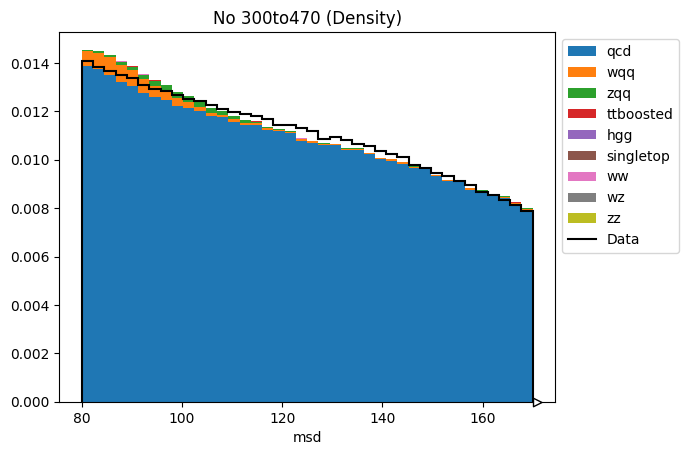

In [72]:
labels = [names for names in new_hists]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', label=labels, density=True)
data_hist.plot1d(label='Data', density=True, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('No 300to470 (Density)')
plt.show()

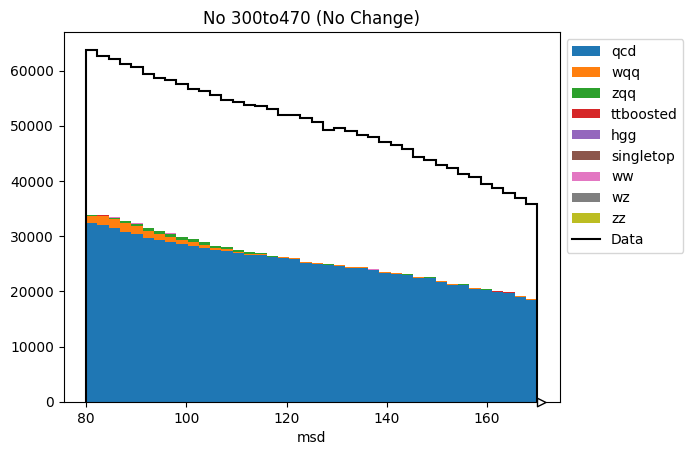

In [73]:
labels = [names for names in new_hists]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', label=labels, density=False)
data_hist.plot1d(label='Data', density=False, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('No 300to470 (No Change)')
plt.show()

In [74]:
new_hists = {}
new_hists['qcd'] = qcd * 1.475
new_hists['wqq'] = wqq
new_hists['zqq'] = zqq
new_hists['ttboosted'] = ttboosted
# new_hists['wlnu'] = wlnu
new_hists['hgg'] = hists['hgg']
new_hists['singletop'] = hists['singletop']
new_hists['ww'] = hists['ww']
new_hists['wz'] = hists['wz']
new_hists['zz'] = hists['zz']

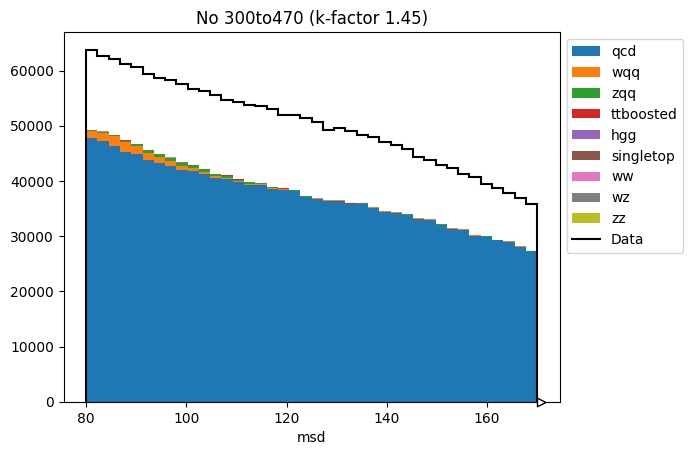

In [75]:
labels = [names for names in new_hists]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', label=labels, density=False)
data_hist.plot1d(label='Data', density=False, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('No 300to470 (k-factor 1.45)')
plt.show()

In [76]:
qcd = sum([hists[i] for i in hists if 'qcd' in i])

In [77]:
new_hists = {}
new_hists['qcd'] = qcd * 0.85
new_hists['wqq'] = wqq
new_hists['zqq'] = zqq
new_hists['ttboosted'] = ttboosted
# new_hists['wlnu'] = wlnu
new_hists['hgg'] = hists['hgg']
new_hists['singletop'] = hists['singletop']
new_hists['ww'] = hists['ww']
new_hists['wz'] = hists['wz']
new_hists['zz'] = hists['zz']

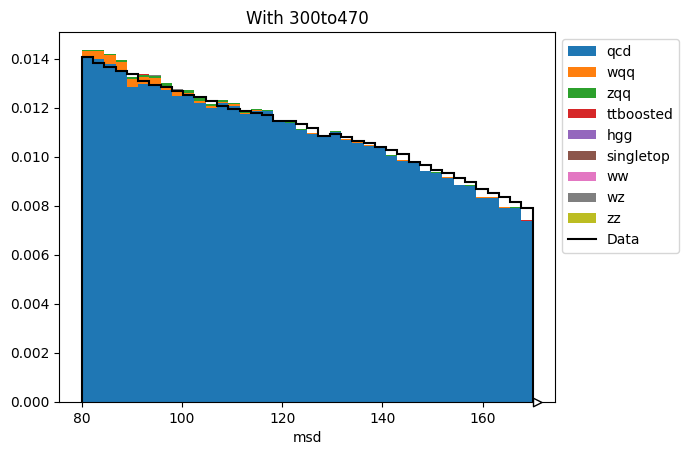

In [78]:
labels = [names for names in new_hists]
hist.Stack.from_iter([new_hists[i] for i in new_hists]).plot(yerr=False, stack=True, histtype='fill', label=labels, density=True)
data_hist.plot1d(label='Data', density=True, yerr=False, color='black')
plt.legend(bbox_to_anchor=(1,1))
plt.title('With 300to470')
plt.show()